In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import *


import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, balanced_accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor


ModuleNotFoundError: No module named 'statsmodels'

In [10]:
data = pd.read_parquet("../Data/stylo_embedds.parquet")

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 208 entries, Author to lex_MarkerCount
dtypes: float64(195), int64(12), object(1)
memory usage: 6.1+ MB


In [ ]:
# Devide features and target variable, scale features

y = data['Author']
X = data.drop(columns=['Author'])

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 207 entries, lex_WordCount to lex_MarkerCount
dtypes: float64(207)
memory usage: 6.1 MB


## Feature selection

In [ ]:
# Helper function to compute VIF
def calculate_vif(X, thresh=10):
    X_df = pd.DataFrame(X)
    dropped = True
    while dropped:
        dropped = False
        vif = pd.Series(
            [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])],
            index=X_df.columns,
        )
        if vif.max() > thresh:
            drop_col = vif.idxmax()
            X_df = X_df.drop(columns=[drop_col])
            dropped = True
    return X_df

# Fisher score computation
def fisher_score(X, y):
    F, _ = f_classif(X, y)
    return pd.Series(F, index=X.columns).sort_values(ascending=False)

# Main function
def feature_selection_pipeline(X, y, classifier=None):
    if classifier is None:
        classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    results = []
    current_X = X.copy()
    y = y.reset_index(drop=True)

    def evaluate_and_log(X_stage, stage_name):
        X_train, X_test, y_train, y_test = train_test_split(
            X_stage, y, test_size=0.2, stratify=y, random_state=42
        )
        clf = clone(classifier)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)

        results.append({
            "Stage": stage_name,
            "Num_features": X_stage.shape[1],
            "Macro_F1": f1_score(y_test, y_pred, average='macro'),
            "Balanced_Accuracy": balanced_accuracy_score(y_test, y_pred),
            "Log_Loss": log_loss(y_test, y_proba)
        })

    # 1. Low Variance Filter
    selector = VarianceThreshold(threshold=0.01)
    X_var = pd.DataFrame(selector.fit_transform(current_X), columns=current_X.columns[selector.get_support()])
    evaluate_and_log(X_var, "VarianceThreshold")
    current_X = X_var

    # 2. Correlation Filter
    corr_matrix = current_X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
    X_corr = current_X.drop(columns=to_drop)
    evaluate_and_log(X_corr, "CorrelationFilter")
    current_X = X_corr

    # 3. VIF Filtering
    X_vif = calculate_vif(current_X, thresh=10)
    evaluate_and_log(X_vif, "VIF_Filter")
    current_X = X_vif

    # 4. L1-based selection with Logistic Regression
    lr = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
    lr.fit(current_X, y)
    coef_mask = lr.coef_.sum(axis=0) != 0  # select non-zero coefficients
    X_l1 = current_X.loc[:, coef_mask]
    evaluate_and_log(X_l1, "L1_LogReg")
    current_X = X_l1

    # 5. Feature Importance from Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(current_X, y)
    importances = pd.Series(rf.feature_importances_, index=current_X.columns)
    selected_features = importances[importances > np.median(importances)].index
    X_rf = current_X[selected_features]
    evaluate_and_log(X_rf, "RandomForest_Importance")
    current_X = X_rf

    # 6. Fisher Score + Iterative Feature Reduction
    fisher_scores = fisher_score(current_X, y)
    for k in range(current_X.shape[1], 2, -5):  # step down by 5 features
        top_features = fisher_scores.head(k).index
        X_fs = current_X[top_features]
        evaluate_and_log(X_fs, f"FisherTop{k}")
    
    # Compile results into DataFrame
    results_df = pd.DataFrame(results)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(results_df["Num_features"], results_df["Macro_F1"], label="Macro F1", marker='o')
    plt.plot(results_df["Num_features"], results_df["Balanced_Accuracy"], label="Balanced Accuracy", marker='o')
    plt.plot(results_df["Num_features"], results_df["Log_Loss"], label="Log Loss", marker='o')
    plt.xlabel("Number of Features")
    plt.ylabel("Metric Value")
    plt.title("Feature Selection vs Performance Metrics")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results_df


## Training classifier

In [5]:
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.to_drop = []

    def fit(self, X, y=None):
        corr_matrix = pd.DataFrame(X).corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        print(f"[CorrelationFilter] Removed {len(self.to_drop)} features (threshold={self.threshold})")
        return self

    def transform(self, X):
        return pd.DataFrame(X).drop(columns=self.to_drop, errors='ignore')

In [6]:
class FeatureTracker(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names_ = []

    def fit(self, X, y=None):
        self.feature_names_ = X.columns.to_list()
        print(f"[Final Features] Feature count: {len(self.feature_names_)}")
        return self

    def transform(self, X):
        return X

    def get_feature_names(self):
        return self.feature_names_

In [27]:
def train_author_classifier(
    data: pd.DataFrame,
    target_col: str = "Author",
    use_scaler: bool = True,
    scaler_type: str = "standard",
    corr_threshold: float = 0.95,
    variance_thresh: float = 1e-5,
    use_boruta: bool = False,
    k_best: int = 1500,
    max_texts_per_author: int = 200,
    model_cls=LogisticRegression,
    model_params=None
):
    if model_params is None:
        model_params = {
            "penalty": "l1",
            "solver": "saga",
            "multi_class": "ovr",
            "class_weight": "balanced",
            "C": 1.0,
            "max_iter": 5000
        }

    X = data.drop(columns=[target_col])
    y = data[target_col]
    X, y = downsample_authors(X, y, max_per_class=max_texts_per_author)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Initial feature count
    print(f"[Initial] Feature count: {X_train.shape[1]}")

    steps = []

    if use_scaler:
        scaler = StandardScaler() if scaler_type == "standard" else MinMaxScaler()
        steps.append(("scaler", scaler))

    # Low Variance Filter
    steps.append(("low_variance", VarianceThreshold(threshold=variance_thresh)))

    # Correlation Filter
    steps.append(("corr_filter", CorrelationFilter(threshold=corr_threshold)))

    # L1-based feature selection
    l1_model = LogisticRegression(**model_params)
    steps.append(("l1_selector", SelectFromModel(l1_model, prefit=False)))

    # Boruta or RF-based selector
    if use_boruta:
        class BorutaSelector(BaseEstimator, TransformerMixin):
            def fit(self, X, y):
                rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
                self.boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=1, random_state=42)
                self.boruta_selector.fit(np.array(X), np.array(y))
                print(f"[Boruta] Selected {self.boruta_selector.support_.sum()} features.")
                self.selected_features = X.columns[self.boruta_selector.support_]
                return self

            def transform(self, X):
                return pd.DataFrame(X, columns=X.columns)[self.selected_features]
        steps.append(("boruta", BorutaSelector()))
    else:
        rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        steps.append(("rf_selector", SelectFromModel(rf_selector)))

    # Final feature tracker
    feature_tracker = FeatureTracker()
    steps.append(("final_features", feature_tracker))

    # Classifier
    steps.append(("classifier", model_cls(**model_params)))

    pipeline = Pipeline(steps, verbose=True)

    # Fit pipeline
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Evaluation
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print("F1 Macro:", f1_score(y_test, y_pred, average='macro'))

    # Confusion Matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y), cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Final selected feature names
    final_features = pipeline.named_steps["final_features"].get_feature_names()
    print(f"\n[Selected Features] Count: {len(final_features)}")
    print(final_features[:10], "...")  # Show first 10

    return pipeline, final_features


In [ ]:
model = train_author_classifier(data)

/var/folders/xn/v7b7dbbn6xg3hzr5h4395gbc0000gn/T/ipykernel_1069/3084532469.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_down = df.groupby("Author", group_keys=False).apply(


[Initial] Feature count: 28389
[Pipeline] ............ (step 1 of 7) Processing scaler, total=   2.9s
[Pipeline] ...... (step 2 of 7) Processing low_variance, total=   1.5s
[CorrelationFilter] Removed 4806 features (threshold=0.95)
[Pipeline] ....... (step 3 of 7) Processing corr_filter, total=58.4min


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


## dedededed

[Initial] Feature count: 207
[Pipeline] ............ (step 1 of 5) Processing scaler, total=   0.0s
[Pipeline] ...... (step 2 of 5) Processing low_variance, total=   0.0s
[CorrelationFilter] Removed 2 features (threshold=0.95)
[Pipeline] ....... (step 3 of 5) Processing corr_filter, total=   0.3s
[Final Features] Feature count: 205
[Pipeline] .... (step 4 of 5) Processing final_features, total=   0.0s


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[Pipeline] ........ (step 5 of 5) Processing classifier, total= 7.0min

--- Classification Report ---
                      precision    recall  f1-score   support

      Alain-Fournier       1.00      0.86      0.92         7
     Alexandre Dumas       0.82      0.93      0.87        40
     Alfred de Vigny       0.72      0.88      0.79        24
     Alphonse Daudet       0.82      0.89      0.86        37
      Anatole France       0.89      0.86      0.87        36
          André Gide       0.93      0.93      0.93        15
      Charles Nodier       1.00      0.75      0.86         8
    François Mauriac       0.90      0.82      0.86        11
         George Sand       0.81      0.72      0.76        40
    Georges Bernanos       1.00      0.83      0.91        12
    Gustave Flaubert       0.85      0.92      0.88        37
   Guy de Maupassant       0.80      0.77      0.78        26
      Henri Barbusse       1.00      1.00      1.00        15
    Honoré de Balzac       0.

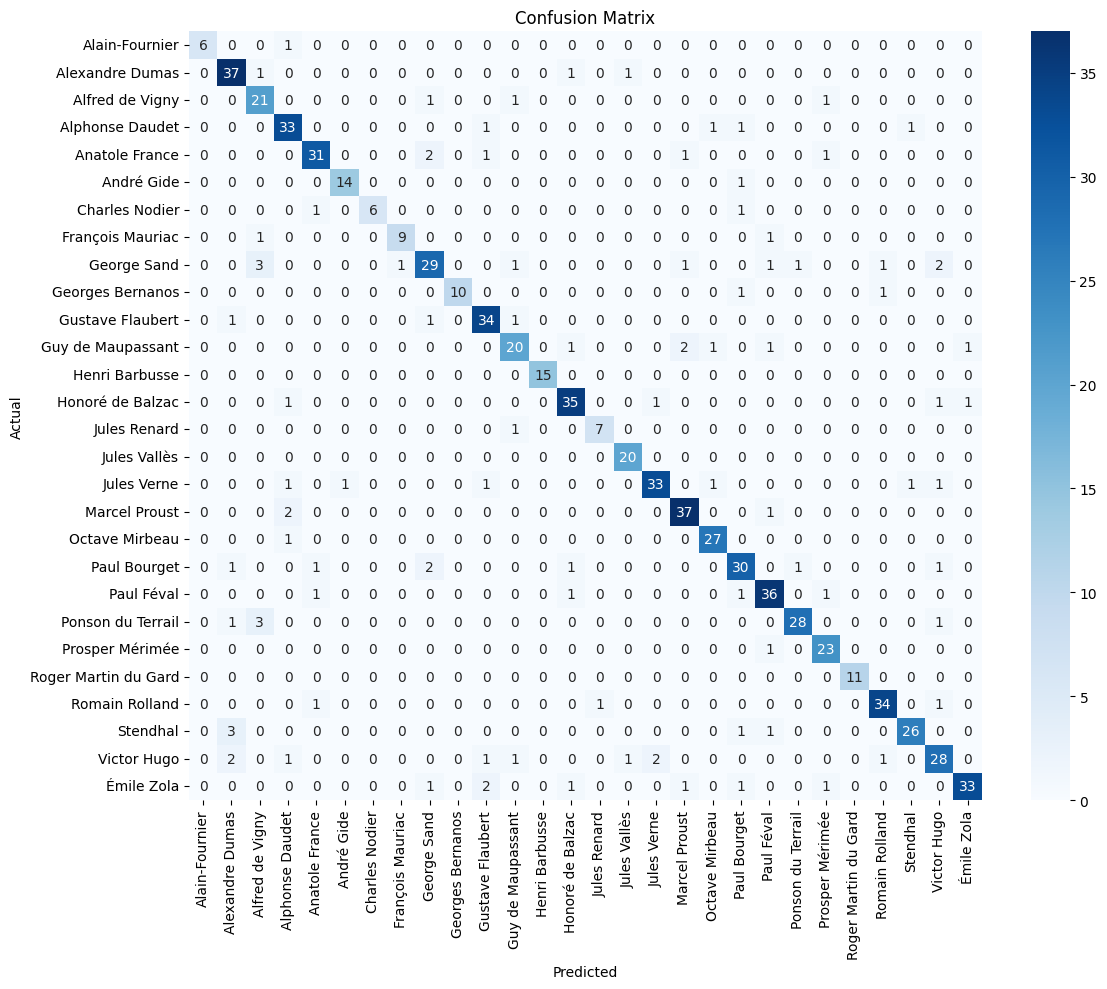


[Selected Features] Count: 205
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ...


In [7]:
def train_author_classifier(
    data: pd.DataFrame,
    target_col: str = "Author",
    use_scaler: bool = True,
    scaler_type: str = "standard",
    corr_threshold: float = 0.95,
    variance_thresh: float = 1e-3,
    model_cls=LogisticRegression,
    model_params=None
):
    if model_params is None:
        model_params = {
            "penalty": "l1",
            "solver": "saga",
            "multi_class": "ovr",
            "class_weight": "balanced",
            "C": 1.0,
            "max_iter": 5000
        }

    X = data.drop(columns=[target_col])
    y = data[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Initial feature count
    print(f"[Initial] Feature count: {X_train.shape[1]}")

    steps = []

    if use_scaler:
        scaler = StandardScaler() if scaler_type == "standard" else MinMaxScaler()
        steps.append(("scaler", scaler))

    # Low Variance Filter
    steps.append(("low_variance", VarianceThreshold(threshold=variance_thresh)))

    # Correlation Filter
    steps.append(("corr_filter", CorrelationFilter(threshold=corr_threshold)))

    # Final feature tracker
    feature_tracker = FeatureTracker()
    steps.append(("final_features", feature_tracker))

    # Classifier
    steps.append(("classifier", model_cls(**model_params)))

    pipeline = Pipeline(steps, verbose=True)

    # Fit pipeline
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Evaluation
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print("F1 Macro:", f1_score(y_test, y_pred, average='macro'))

    # Confusion Matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y), cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Final selected feature names
    final_features = pipeline.named_steps["final_features"].get_feature_names()
    print(f"\n[Selected Features] Count: {len(final_features)}")
    print(final_features[:10], "...")  # Show first 10

    return pipeline, final_features
model = train_author_classifier(data)

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def run_grid_search_author_classifier(data: pd.DataFrame, target_col: str = "Author"):
    X = data.drop(columns=[target_col])
    y = data[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    class OptionalScaler(BaseEstimator, TransformerMixin):
        def __init__(self, use_scaler=True, scaler_type="standard"):
            self.use_scaler = use_scaler
            self.scaler_type = scaler_type
            self.scaler = None

        def fit(self, X, y=None):
            if self.use_scaler:
                self.scaler = StandardScaler() if self.scaler_type == "standard" else MinMaxScaler()
                self.scaler.fit(X)
            return self

        def transform(self, X):
            return self.scaler.transform(X) if self.use_scaler else X

    pipeline = Pipeline([
        ("scaler", OptionalScaler()),
        ("low_variance", VarianceThreshold()),
        ("corr_filter", CorrelationFilter()),  # suppose que c'est un Transformer maison
        ("classifier", LogisticRegression(max_iter=5000, class_weight="balanced"))
    ])

    param_grid = {
        "scaler__use_scaler": [True, False],
        "scaler__scaler_type": ["standard", "minmax"],
        "low_variance__threshold": [1e-4, 1e-3, 1e-2],
        "corr_filter__threshold": [0.90, 0.95, 0.99],
        "classifier__C": [0.1, 1.0, 10],
        "classifier__penalty": ["l1", "l2"],
        "classifier__solver": ["saga"]
    }

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=3,
        scoring="f1_macro",
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("\n✅ Best Parameters:")
    print(grid_search.best_params_)

    y_pred = best_model.predict(X_test)

    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print("F1 Macro:", f1_score(y_test, y_p_


SyntaxError: incomplete input (2464576484.py, line 72)

In [ ]:
run_grid_search_author_classifier(data)